# <span style="color:pink"> AUTORES </span>
 
* **<span style="color:pink"> Sebastián Kay Conde Lorenzo </span>**
* **<span style="color:pink"> Francisco Manuel López López </span>**

# <span style="color:red">¿DÓNDE ENCONTRAR LAS IMÁGENES, NOTAS Y DEMÁS?</span>

**<span style="color:red">PARA ENCONTRAR EL PROYECTO COMPLETO DE ESTOS NOTEBOOKS (INCLUYENDO LA ESTRUCTURA DE CARPETAS E IMÁGENES USADAS) POR FAVOR VISITAR ESTE [REPOSITORIO](https://github.com/cbasitodx/Image_Processing_Course)**</span>

In [1]:
import cv2
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from PIL.ExifTags import GPSTAGS
from PIL.ExifTags import TAGS
import json

from skimage.color import rgb2lab, rgb2hsv
from skimage.transform import resize

## Tarea 1: 

El objetivo de esta tarea es cargar una imágen cualquiera y trabajar los conceptos más básicos sobre ella.

Empezando por cómo cargarla y cómo modificar su tamaño (alto y ancho, ambos medidos en número de píxeles).

Luego, se extrae su brillo y contraste. También se extrae el número de canales (que serán 3 en RGB por ser una imágen a color) y las intensidades (valores de los píxeles) mínimas y máximas por cada canal.

Seguidamente, se extrae el histograma de frecuencias de intensidades por cada canal, y se altera la resolución radiométrica (número de píxeles usados para representar la imágen) de la imágen en escala de grises.

Por último, se extraen los metadatos de la imágen, incluyendo la ubicación (latitud y longitud) de donde se capturó la imágen.

In [3]:
IMAGE_FILE = "./imagenes/notebook_1/bobby.jpg"

### Apertura de una imagen

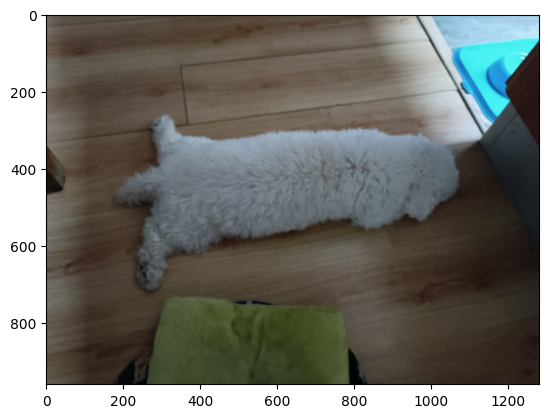

In [4]:
# Using opencv library
im = cv2.imread(IMAGE_FILE) # It opens images as BGR instead of RGB

plt.imshow(im[:,:,[2,1,0]]) # We need to change the order of the channels
plt.show()

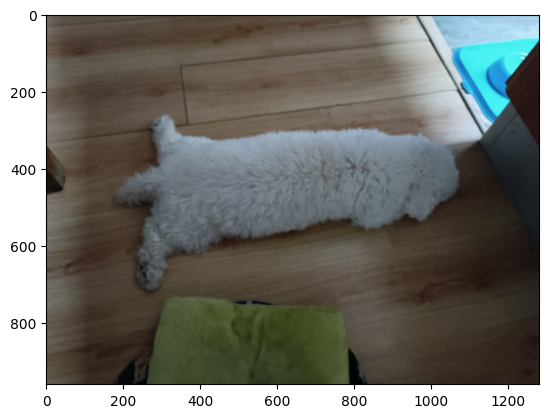

In [4]:
im = imread(IMAGE_FILE)

plt.imshow(im)
plt.show()

### Modificar el tamaño de la imagen

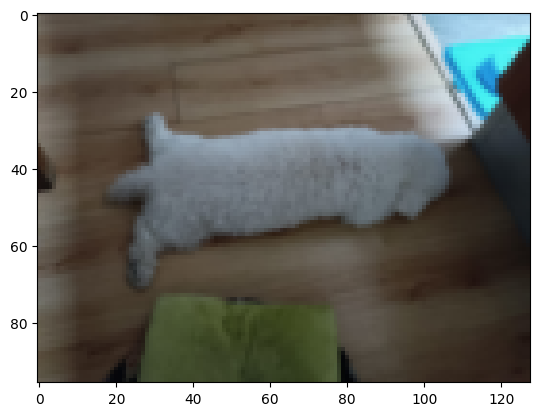

In [5]:
im_resized = resize(im, (96, 128), anti_aliasing=True) 

plt.imshow(im_resized)
plt.show()

### Características de una imagen

In [6]:
def brightness(im, bit_cod=8):
    """ Function to estimate the average light intensity.
    """
    im = im / (2**bit_cod)
    b = np.sum(im) / (im.shape[0] * im.shape[1])
    return b * (2**bit_cod)

def contrast(im, bit_cod=8):
    """ Function to estimate the difference in intensities.
    """
    im = im / (2**bit_cod)
    b = brightness(im, bit_cod=bit_cod)
    c = np.sum(np.square(im - b)) / (im.shape[0] * im.shape[1])
    return c * (2**bit_cod)


In [7]:
im = imread(IMAGE_FILE)
height, width, channels = im.shape

print('Image Size: {} x {}'.format(height, width))
print('Number of channels: {}'.format(channels))
print('Max intensity: {}'.format(['channel {}: {}'.format(band + 1, np.max(im[:,:,band])) 
                                  for band in range(im.shape[2])]))
print('Min intensity: {}'.format(['channel {}: {}'.format(band + 1, np.min(im[:,:,band])) 
                                  for band in range(im.shape[2])]))
print('Brightness: {}'.format(['channel {}: {:0.2f}'.format(band + 1, brightness(im[:,:,band])) 
                               for band in range(im.shape[2])]))
print('Contrast: {}'.format(['channel {}: {:0.2f}'.format(band + 1, contrast(im[:,:,band])) 
                             for band in range(im.shape[2])]))

Image Size: 960 x 1280
Number of channels: 3
Max intensity: ['channel 1: 221', 'channel 2: 255', 'channel 3: 255']
Min intensity: ['channel 1: 0', 'channel 2: 1', 'channel 3: 3']
Brightness: ['channel 1: 87.57', 'channel 2: 87.25', 'channel 3: 79.47']
Contrast: ['channel 1: 4.69', 'channel 2: 7.59', 'channel 3: 10.48']


### Histograma

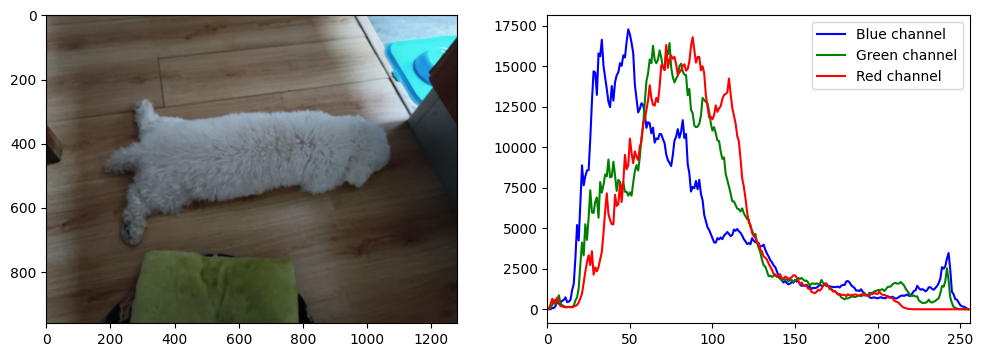

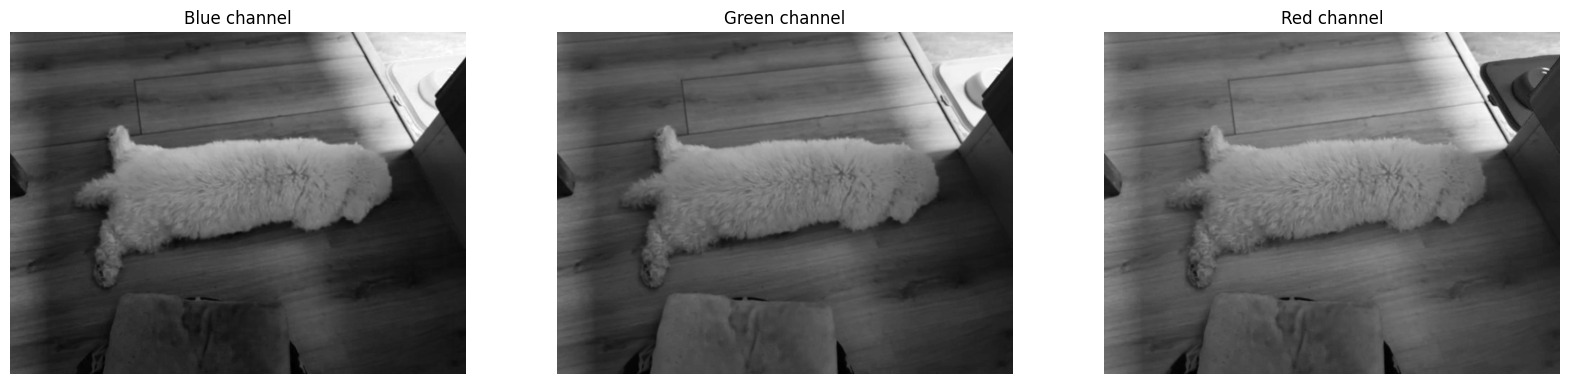

In [8]:
img = cv2.imread(IMAGE_FILE)

plt.figure(figsize=(12,4))

# Subplot image
plt.subplot(121)
plt.imshow(img[:,:,[2,1,0]])

# Subplot histogram
plt.subplot(122)
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,255])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.legend(('Blue channel','Green channel','Red channel'))
plt.show()

colors = ['Blue channel','Green channel','Red channel']
fig = plt.figure(figsize=(20,10))
for i in range(img.shape[2]):
    ax = fig.add_subplot(1, img.shape[2], i+1)
    ax.set_title(colors[i])
    ax.axis('off')
    ax.imshow(img[:,:,i], cmap='gray')
plt.show()

#### Modificar la resolución radiométrica

In [9]:
def reduce_bits(image, input_bits, target_bits):
    """
    Reduces the number of bits in an image.
    """
    max_val = 2 ** target_bits - 1  # Maximum value for the target bit depth
    
    # Scale image to [0, max_val], quantize, then rescale to original range
    scaled = np.floor(image / (2 ** input_bits - 1) * max_val).astype(np.uint8)
    result = (scaled / max_val * (2 ** input_bits - 1)).astype(np.uint8)    
    return result

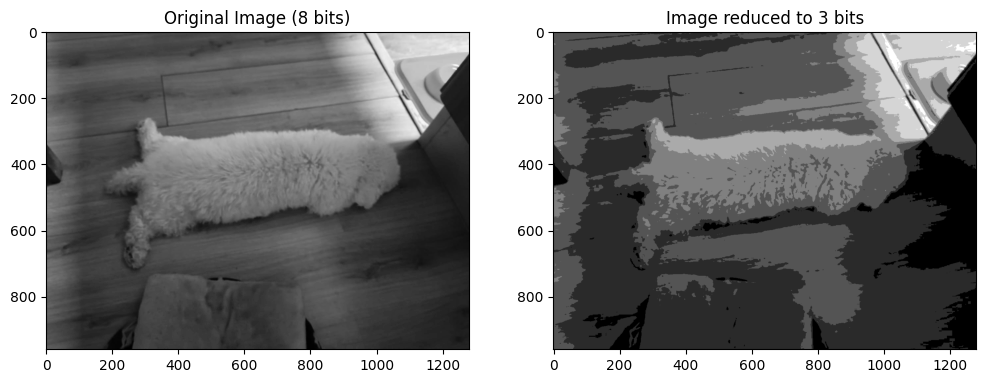

In [10]:
im = imread(IMAGE_FILE)
im_gray = np.mean(im, axis=2).astype(np.uint8) # Convert RGB into grayscale

reduced_image = reduce_bits(im_gray, input_bits=8, target_bits=3)

# Display the original and reduced-bit images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image (8 bits)")
plt.imshow(im_gray, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Image reduced to 3 bits")
plt.imshow(reduced_image, cmap='gray')

plt.show()


### Obtención de Metadatos

In [11]:
def get_exif(filename):
    """ Function to get metadata.
    """
    image = Image.open(filename)
    image.verify()
    return image._getexif()

def get_labeled_exif(exif):
    """ Function to get metadata as a dictionary omitting 'MakerNote' tag (iphone).
    """
    labeled = {}
    for (key, val) in exif.items():
        if TAGS.get(key) != 'MakerNote': # Avoid marker note of iphone
            labeled[TAGS.get(key)] = val
    return labeled

def get_geotagging(exif):
    """ Function to get geospatial metadata.
    """
    if not exif:
        raise ValueError("No EXIF metadata found")
    geotagging = {}
    for (idx, tag) in TAGS.items():
        if tag == 'GPSInfo':
            if idx not in exif:
                raise ValueError("No EXIF geotagging found")

            for (key, val) in GPSTAGS.items():
                if key in exif[idx]:
                    geotagging[val] = exif[idx][key]
    return geotagging

def get_decimal_from_dms(dms, ref):
    """ Function to convert dms (decimal, minute, second) coordinates 
        to decimal coordinates.
    """
    degrees = dms[0]
    minutes = dms[1] / 60.0
    seconds = dms[2] / 3600.0
    if ref in ['S', 'W']:
        degrees = -degrees
        minutes = -minutes
        seconds = -seconds
    return round(degrees + minutes + seconds, 5) 

def get_coordinates(geotags):
    """ Function to get spatial coordinates.
    """
    lat = get_decimal_from_dms(geotags['GPSLatitude'], geotags['GPSLatitudeRef'])

    lon = get_decimal_from_dms(geotags['GPSLongitude'], geotags['GPSLongitudeRef'])
    return (lat,lon) 

In [12]:
# Nota: Tuve que tomar otra foto porque la que estaba usando (bobby.jpg) tenia los metadatos eliminados
IMAGE_FILE_METADATA : str = "imagenes/notebook_1/bobby_metadatos.jpg"

exif = get_exif(IMAGE_FILE_METADATA) 

metadata = get_labeled_exif(exif) # obtain metadata
metadata

{'ImageWidth': 4080,
 None: '163',
 'ImageLength': 3072,
 'GPSInfo': {0: b'\x02\x02\x00\x00',
  1: 'N',
  2: (40.0, 23.0, 44.5776),
  3: 'W',
  4: (3.0, 46.0, 20.28504),
  5: b'\x00',
  6: 717.3999,
  7: (17.0, 42.0, 49.0),
  12: 'K',
  13: 0.0,
  27: 'network',
  29: '2024:12:06'},
 'ResolutionUnit': 2,
 'ExifOffset': 476,
 'ImageDescription': '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00',
 'Make': 'Xiaomi',
 'Model': '23053RN02Y',
 'Software': 'MediaTek Camera Application\x00\x00\x00\x00',
 'Orientation': 1,
 'DateTime': '2024:12:06 18:42:54',
 'YCbCrPositioning': 2,
 'XResolution': 72.0,
 'YResolution': 72.0,
 'ExifVersion': '0220',
 'ColorSpace': 1,
 'FlashPixVersion': b'0100',
 'ExifImageHeight': 3072,
 'ExposureBiasValue': 0.0,
 'MaxApertureValue': 0.0,
 'BrightnessValue': 0.0,
 'DateTimeOriginal': '2024:12:06 18:42:54',
 'WhiteBalance': 0,
 'ExifInteroperabilityOffset': 3731,
 'ExposureMode': 0,
 'F

In [13]:
# Get coordinates from picture
geotags = get_geotagging(exif)
print(geotags)
coordinates = get_coordinates(geotags) 

print('Coordinates. Latitude: {}, Longitude: {}'.format(coordinates[1], coordinates[0]))

{'GPSVersionID': b'\x02\x02\x00\x00', 'GPSLatitudeRef': 'N', 'GPSLatitude': (40.0, 23.0, 44.5776), 'GPSLongitudeRef': 'W', 'GPSLongitude': (3.0, 46.0, 20.28504), 'GPSAltitudeRef': b'\x00', 'GPSAltitude': 717.3999, 'GPSTimeStamp': (17.0, 42.0, 49.0), 'GPSSpeedRef': 'K', 'GPSSpeed': 0.0, 'GPSProcessingMethod': 'network', 'GPSDateStamp': '2024:12:06'}
Coordinates. Latitude: -3.7723, Longitude: 40.39572


# Tarea 2:

Explorar los espacios de color con dos imágenes idénticas pero tomadas en condiciones lumínicas diferentes. Los espacios de color a explorar serán **RGB**, **HSV** y **CIELab**.

In [14]:
# Imagenes a usar:
im1 = cv2.rotate(imread("imagenes/notebook_1/alien_claro.jpg"), cv2.ROTATE_90_CLOCKWISE) 
im2 = imread("imagenes/notebook_1/alien_oscuro.jpg")

### Espacios de Color

#### RGB

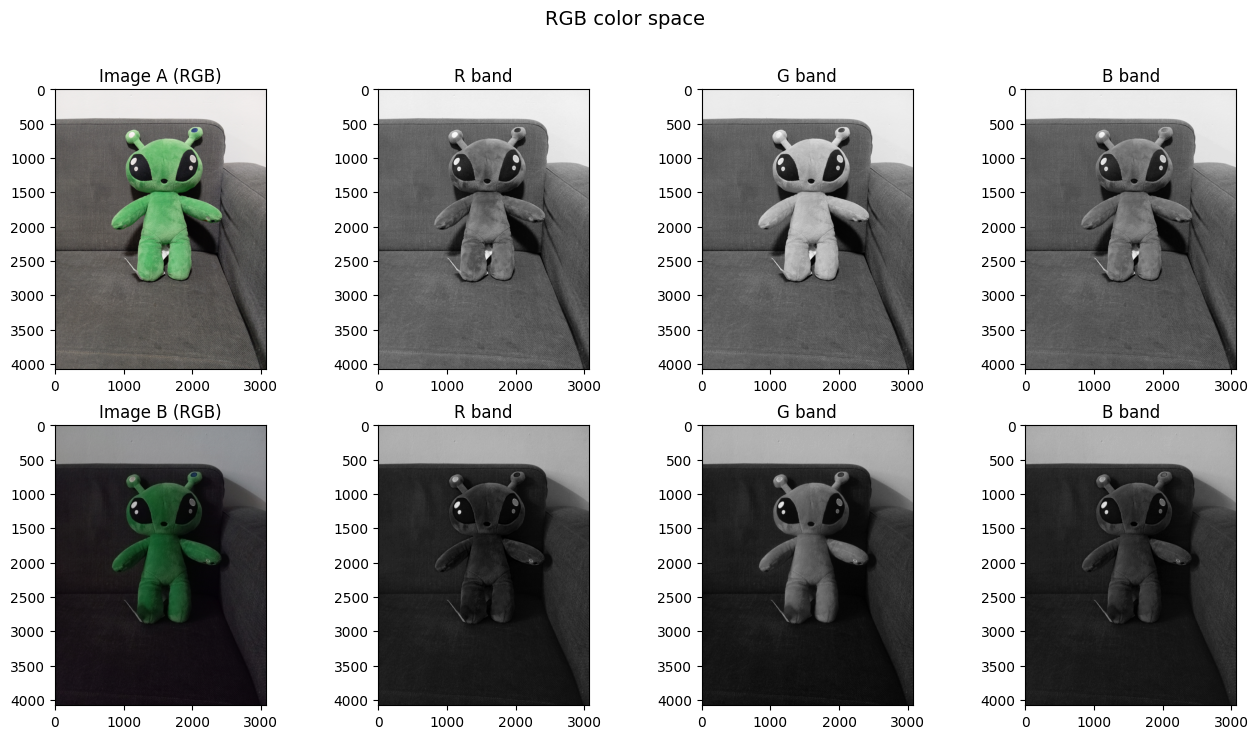

In [15]:
# Ploting images
fig = plt.figure(figsize=(16, 8))
fig.suptitle('RGB color space', fontsize=14)

plt.subplot(241)
plt.imshow(im1)
plt.title('Image A (RGB)')

plt.subplot(242)
plt.imshow(im1[:,:,0], cmap='gray')
plt.title('R band')

plt.subplot(243)
plt.imshow(im1[:,:,1], cmap='gray')
plt.title('G band')

plt.subplot(244)
plt.imshow(im1[:,:,2], cmap='gray')
plt.title('B band')

plt.subplot(245)
plt.imshow(im2)
plt.title('Image B (RGB)')

plt.subplot(246)
plt.imshow(im2[:,:,0], cmap='gray')
plt.title('R band')

plt.subplot(247)
plt.imshow(im2[:,:,1], cmap='gray')
plt.title('G band')

plt.subplot(248)
plt.imshow(im2[:,:,2], cmap='gray')
plt.title('B band')

plt.show()

#### HSV

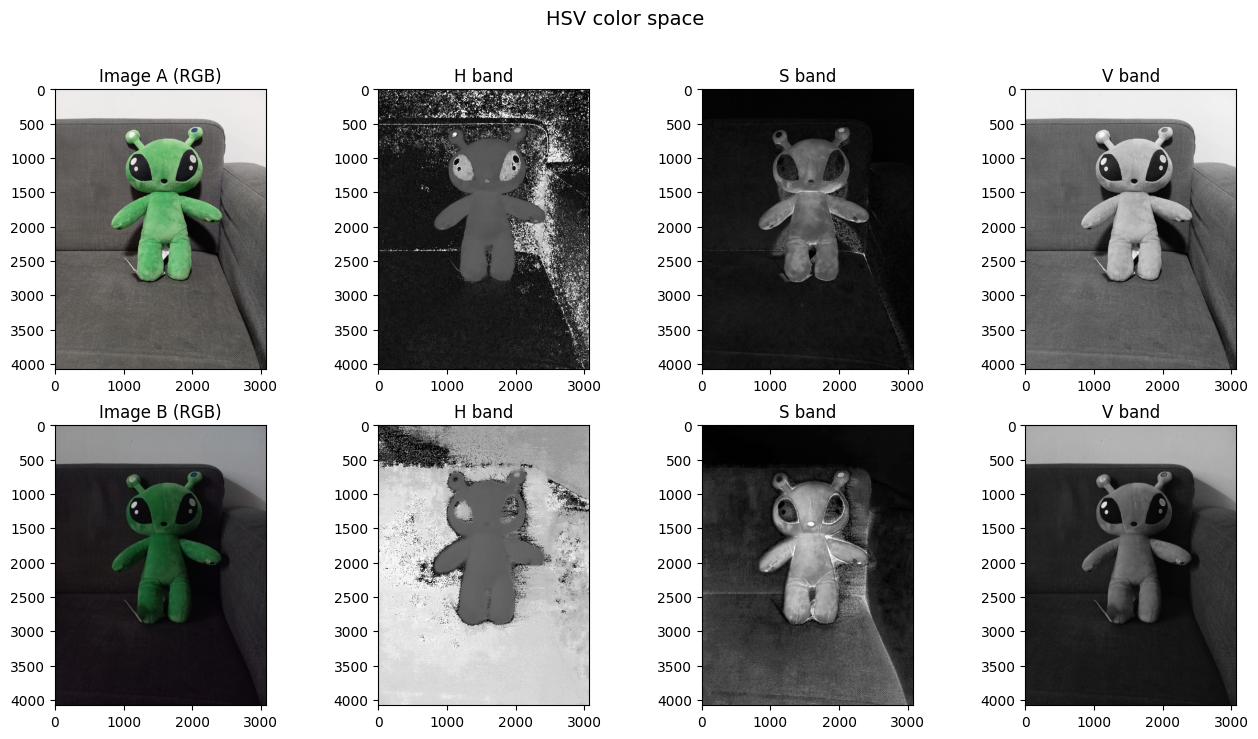

In [16]:
im1_hsv = rgb2hsv(im1)
im2_hsv = rgb2hsv(im2)

# Ploting images
fig = plt.figure(figsize=(16, 8))
fig.suptitle('HSV color space', fontsize=14)

plt.subplot(241)
plt.imshow(im1)
plt.title('Image A (RGB)')

plt.subplot(242)
plt.imshow(im1_hsv[:,:,0], cmap='gray')
plt.title('H band')

plt.subplot(243)
plt.imshow(im1_hsv[:,:,1], cmap='gray')
plt.title('S band')

plt.subplot(244)
plt.imshow(im1_hsv[:,:,2], cmap='gray')
plt.title('V band')

plt.subplot(245)
plt.imshow(im2)
plt.title('Image B (RGB)')

plt.subplot(246)
plt.imshow(im2_hsv[:,:,0], cmap='gray')
plt.title('H band')

plt.subplot(247)
plt.imshow(im2_hsv[:,:,1], cmap='gray')
plt.title('S band')

plt.subplot(248)
plt.imshow(im2_hsv[:,:,2], cmap='gray')
plt.title('V band')

plt.show()

#### CIELab color space

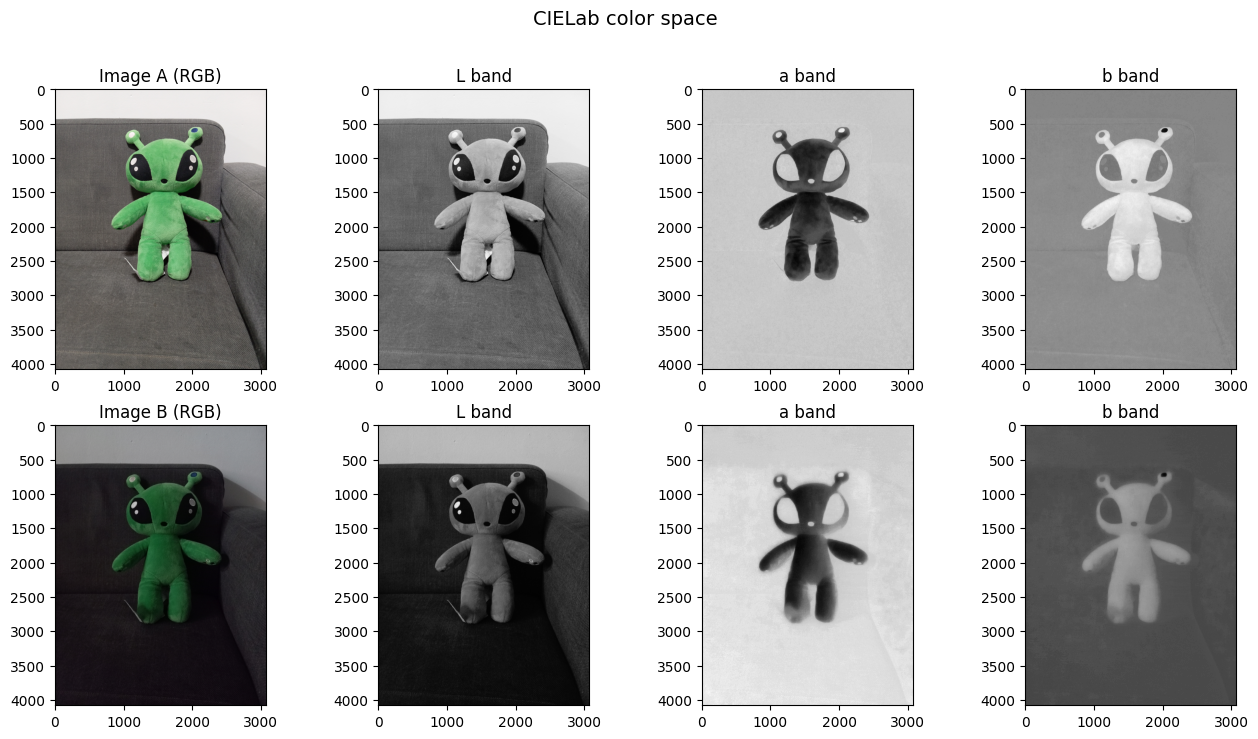

In [17]:
im1_lab = rgb2lab(im1)
im2_lab = rgb2lab(im2)

# Ploting images
fig = plt.figure(figsize=(16, 8))
fig.suptitle('CIELab color space', fontsize=14)

plt.subplot(241)
plt.imshow(im1)
plt.title('Image A (RGB)')

plt.subplot(242)
plt.imshow(im1_lab[:,:,0], cmap='gray')
plt.title('L band')

plt.subplot(243)
plt.imshow(im1_lab[:,:,1], cmap='gray')
plt.title('a band')

plt.subplot(244)
plt.imshow(im1_lab[:,:,2], cmap='gray')
plt.title('b band')

plt.subplot(245)
plt.imshow(im2)
plt.title('Image B (RGB)')

plt.subplot(246)
plt.imshow(im2_lab[:,:,0], cmap='gray')
plt.title('L band')

plt.subplot(247)
plt.imshow(im2_lab[:,:,1], cmap='gray')
plt.title('a band')

plt.subplot(248)
plt.imshow(im2_lab[:,:,2], cmap='gray')
plt.title('b band')

plt.show()